<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/pytorch/4%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

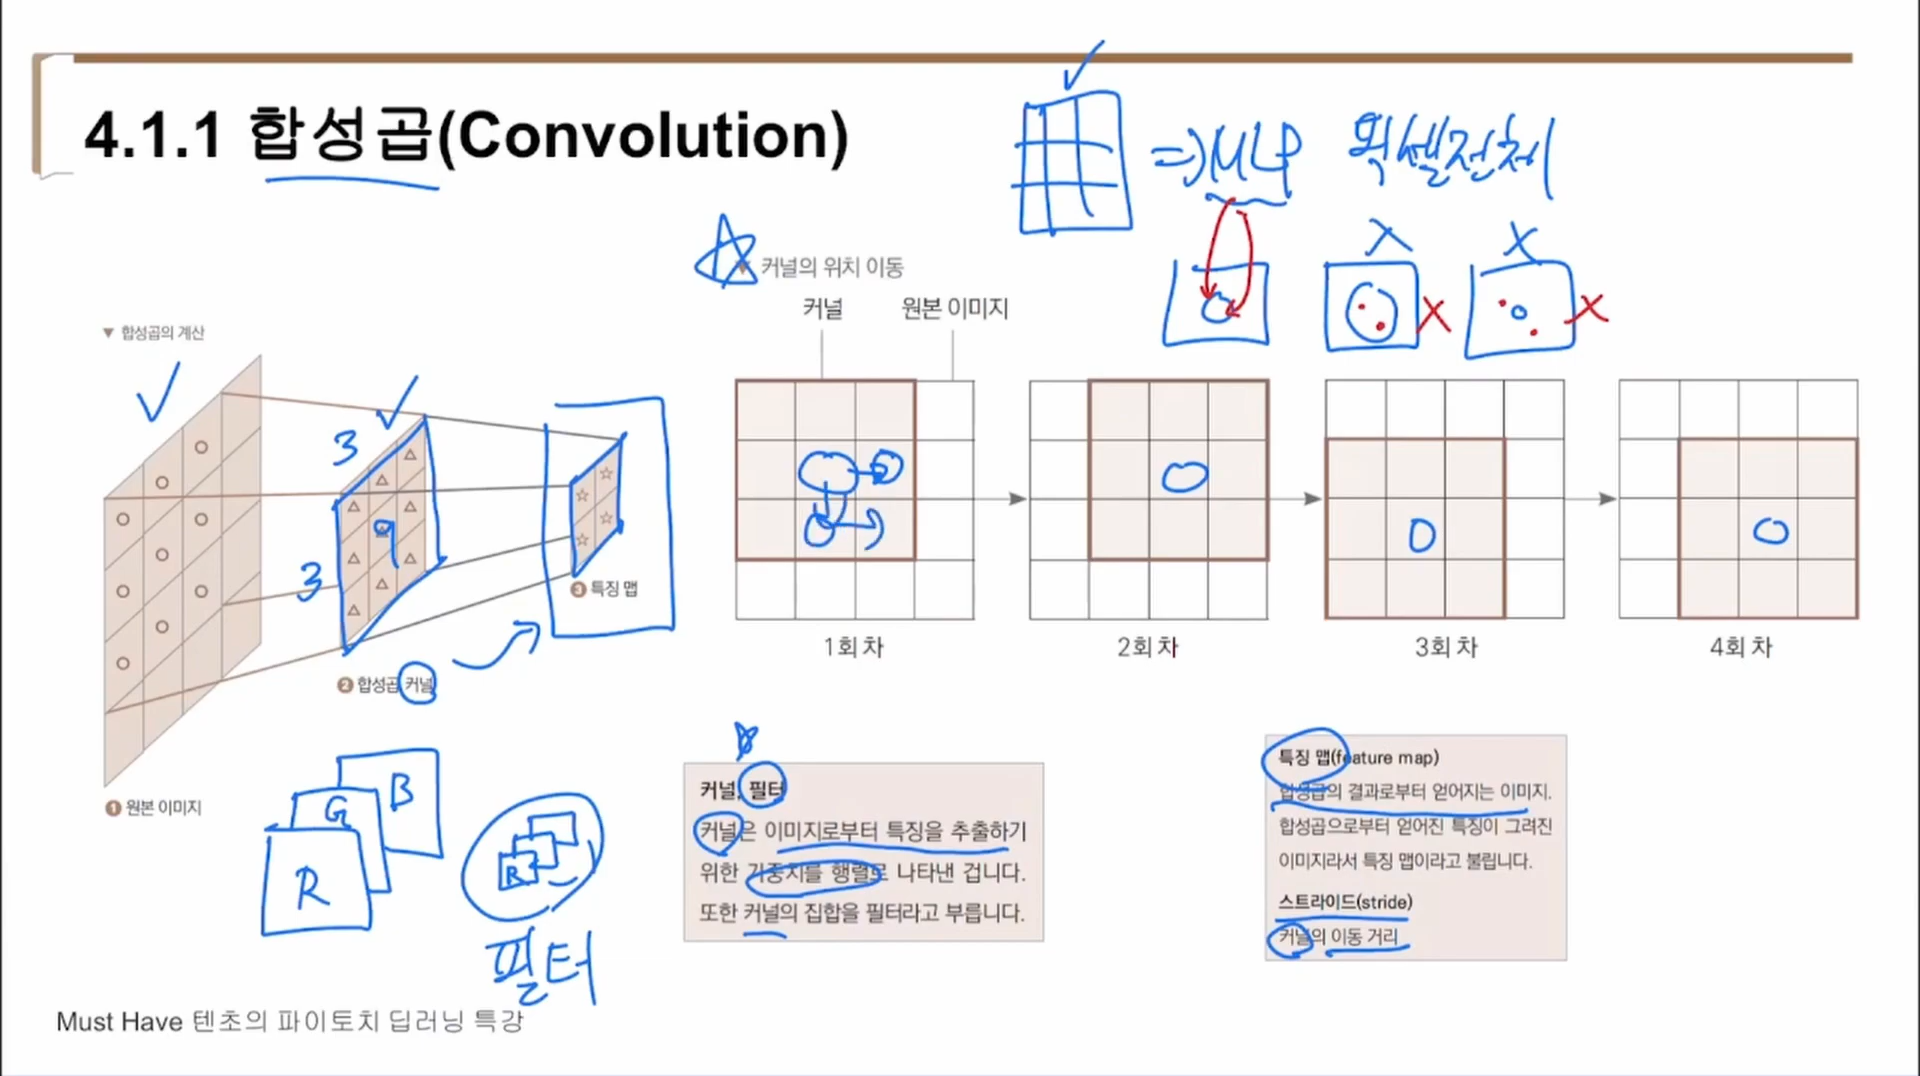

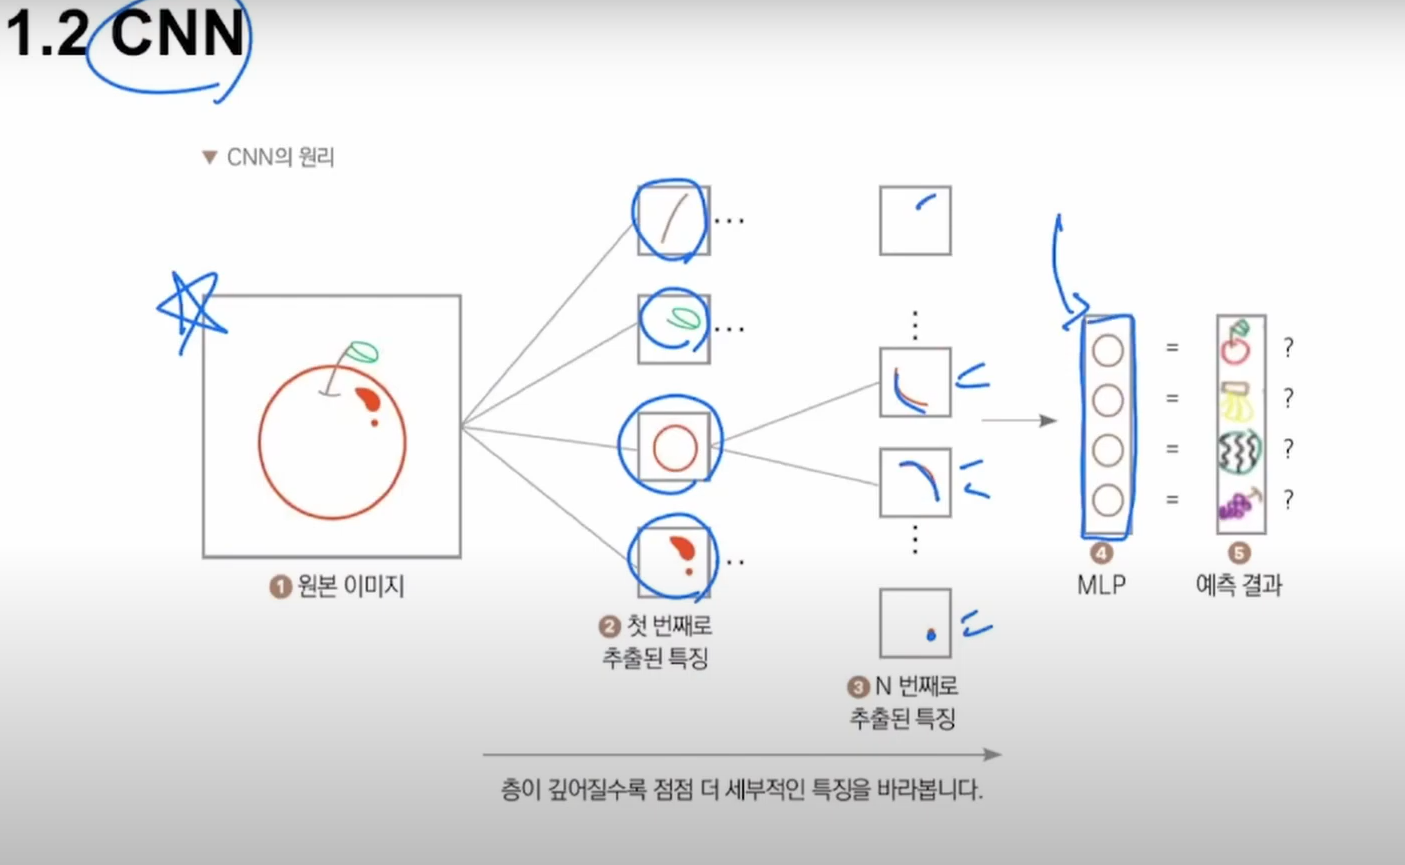

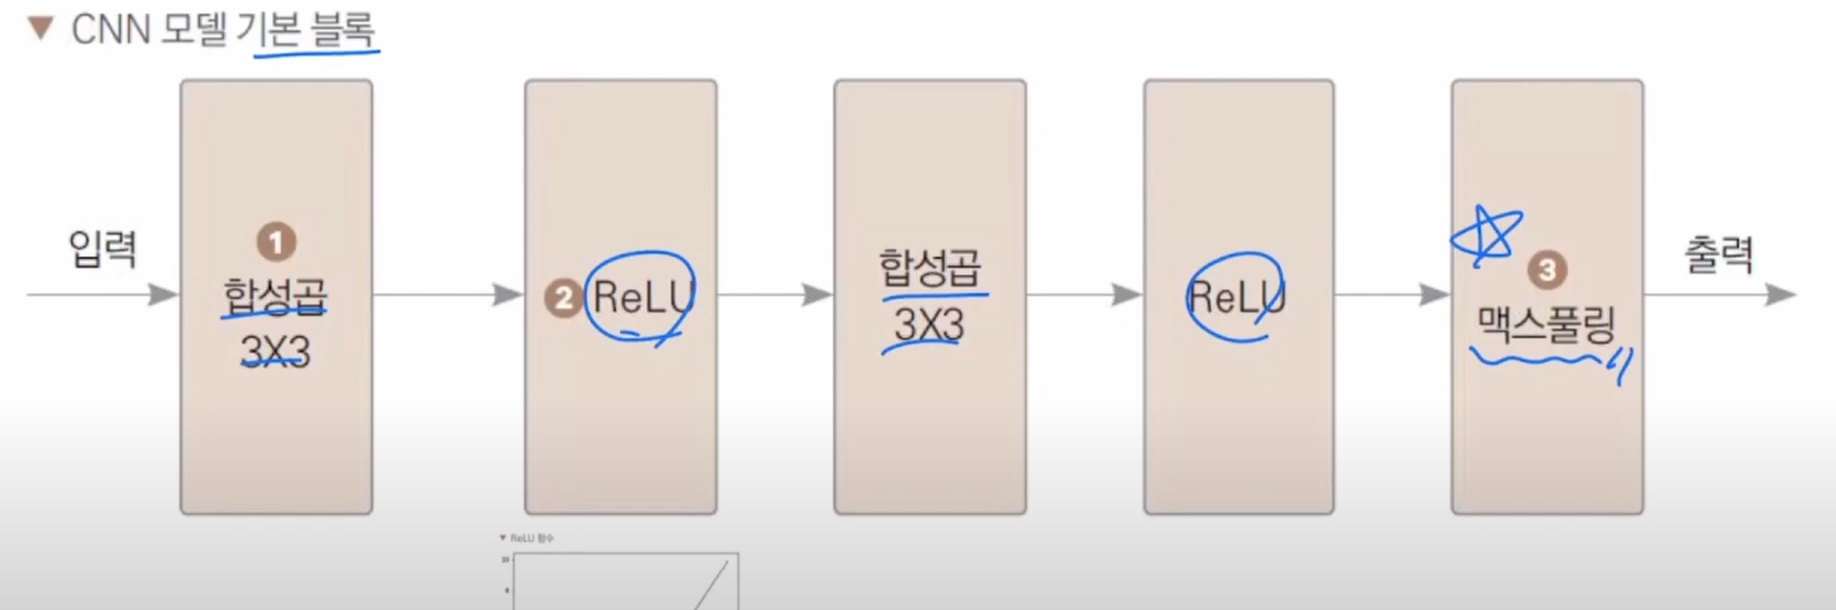

맥스풀링
과학습을 막기위함

#CNN을 만들어 사물 이미지를 분류하는 모델을 만들기

100%|██████████| 170498071/170498071 [00:03<00:00, 48915587.13it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


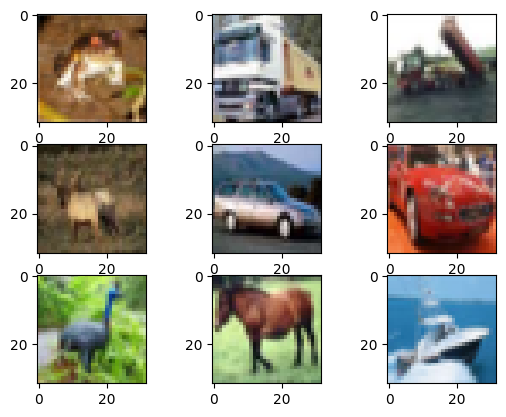

In [1]:
#데이터 전처리하기

#데이터 살펴보기
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
#CIFAR-10데이터셋 불러오기

training_data = CIFAR10(
    root = "./",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform = ToTensor()
)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(training_data.data[i])
plt.show()

Files already downloaded and verified
Files already downloaded and verified


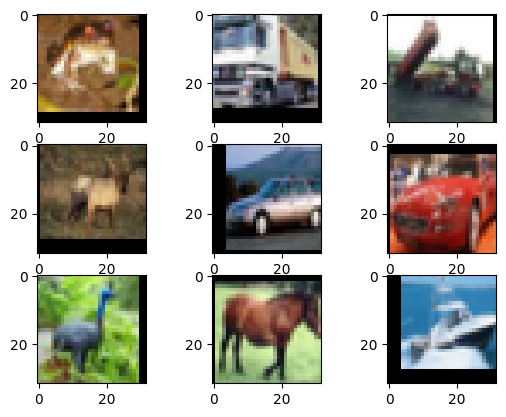

In [7]:
#데이터 증강

#데이터 전처리에 크롭핑과 좌우대칭 추가

import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ #데이터 전처리 함수
  T.ToPILImage(),
  RandomCrop((32,32),padding=4), #랜덤으로 이미지 일부 제거 후 패딩
  RandomHorizontalFlip(p=0.5), #y축으로 기준으로 대칭
])
  
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms)#transform에는 데이터를 변환하는 함수가 들어감

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms
)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

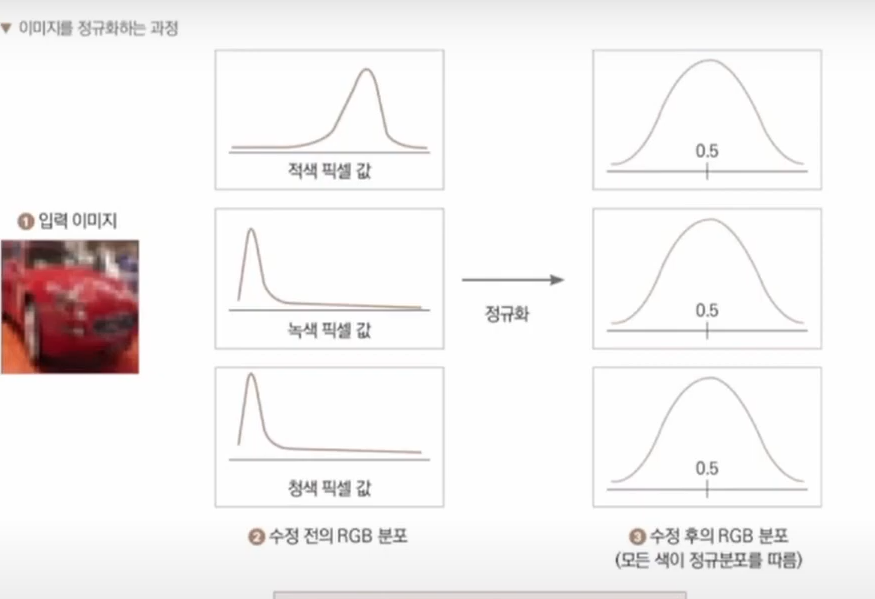

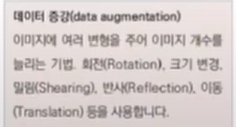

Files already downloaded and verified
Files already downloaded and verified


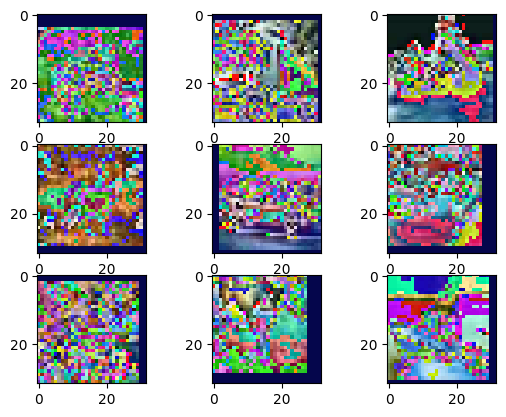

In [8]:
#이미지 정규화

#데이터 전처리에 정규화 추가

import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

#데이터 전처리 정의
transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243,0.261)),
    T.ToPILImage(),
])

#학습용 데이터 정의
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms
)

#평가용 데이터 정의
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms
)

#이미지 표시
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

In [9]:
#데이터셋의 평균과 표준편차

import torch
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor()
)

#item[0]은 이미지,item[1]은 정답레이블
imgs = [item[0] for item in training_data]

#imgs를 하나로 합침
imgs=torch.stack(imgs, dim=0).numpy()

#rgb각 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

#rgb 각 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


In [10]:
#VGG 기본블록 정의

import torch
import torch.nn as nn

class BasicBlock(nn.Module): #기본블록정의
  #기본 블록을 구성하는 층 정의
  def __init__(self,inchannels, out_channels, hidden_dim):
    #nn.Module 클래스의 요소 상속
    super(BasicBlock, self).__init__()

    #합성곱층 정의
    self.conv1 = nn.Conv2d(in_channels, hidden_dim,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(hidden_dim,out_channels,kernel_size=3,padding=1)
    self.relu = nn.ReLU()

    #stride는 커널의 이동거리
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x): #기본 블록의 순전파 정의
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    return x

In [11]:
class CNN(nn.Module):
  def __init__(self,num_classes): #num_classes는 클래스 개수
    super(CNN, self).__init__()

    #합성곱 기본 블록정의
    self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
    self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
    self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

    #분류기 정의
    self.fc1 = nn.Linear(in_features=4096, out_features=2048)
    self.fc2 = nn.Linear(n_features=2048, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.relu = nn.ReLU

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x) #출력 모양: (-1,256,4,4)
    x = torch.flatten(x,start_dim=1) #2차원 특징 맵을 1차원으로

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = welf.fc3(x)

    return x

In [12]:
#모델 학습하기
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam
transforms = Compose([
    RandomCrop((32,32),padding=4),#랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), #y축으로 좌우대칭
    ToTensor(),#텐서로 변환
    #이미지 정규화
    Normalize(mean=(0.4914,0.4822, 0.4465),std=(0.247, 0.243, 0.261))
])

In [13]:
#데이터 로드 및 모델 정의

#학습용 데이터와 평가용 데이터 불러오기
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

#데이터로더 정의
train_loader = DataLoader(training_data, batch_size= 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#핛브을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

#CNN모델 정의
model = CNN(num_classes=10)

#모델을 device로 보냄
model.to(device)


Files already downloaded and verified
Files already downloaded and verified


TypeError: ignored

In [14]:
#모델 학습하기
#학습률 정의
lr = 1e-3
#최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

#학습 루프 정의
for epoch in range(100):
  for data, label in train_loader: #데이터 호출
    optim.zero_grad() # 기울기 초기화
    preds = model(data.to(device)) #모델의 예측

    #오차 역전파와 최적화
    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()
  
  if epoch==0 or epoch%10==9: #10번마다 손실 출력
    print(f"epoch{epoch+1} loss:{loss.item()}")

#모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

NameError: ignored

In [15]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
  for data, label in test_loader:

    output = model(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr

  print(f"Accuracy:{num_corr/len(test_data)}")

NameError: ignored

#전이 학습 모델 VGG로 분류하기

In [16]:
#사전학습된 모델 준비
import torch
import torch.nn as nn

from torchvision.models.vgg import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"

model = vgg16(pretrained=True) #vgg16 모델 객체 생성
fc = nn.Sequential( #분류층의 정의
       nn.Linear(512 * 7 * 7, 4096),
       nn.ReLU(),
       nn.Dropout(), #드롭아웃층 정의
       nn.Linear(4096, 4096),
       nn.ReLU(),
       nn.Dropout(),
       nn.Linear(4096, 10),
   )

model.classifier = fc #VGG의 classifier를 덮어씀
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

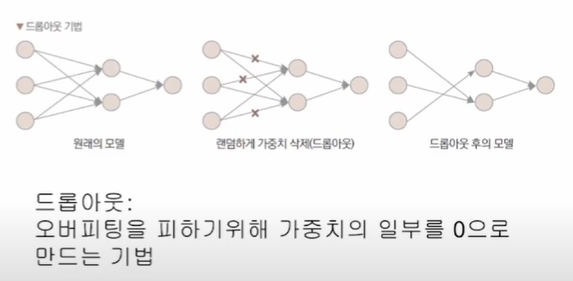

In [17]:
#데이터 전처리와 증강

import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
   Resize(224),
   RandomCrop((224, 224), padding=4),
   RandomHorizontalFlip(p=0.5),
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [18]:
#데이터로더 정의
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#학습 루프 정의
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

for epoch in range(5):
   iterator = tqdm.tqdm(train_loader) #학습 로그 출력
   for data, label in iterator:
       optim.zero_grad()

       preds = model(data.to(device)) # 모델의 예측값 출력

       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()
     
       #tqdm이 출력할 문자열
       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained.pth") #모델 저장

epoch:1 loss:1.012954831123352:   3%|▎         | 46/1563 [51:28<28:16:24, 67.10s/it]

In [ ]:
#모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")